# Exploring CVXPY

Exploring CVXPY for L1-regularized complex least squares

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import cvxpy as cvx
import numpy as np

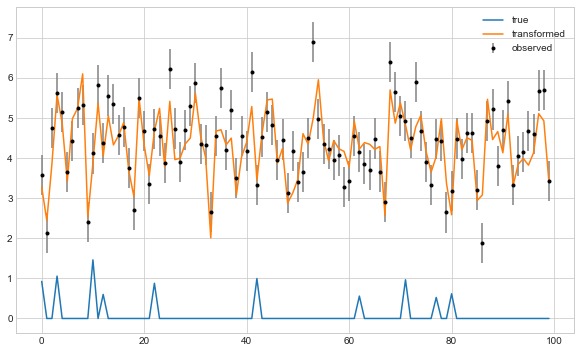

In [2]:
def make_data(N=100, M=100, K=10, sigma=0.5, rseed=543, cplx=False):
    rand = np.random.RandomState(rseed)
    A = rand.rand(N, M)
    x = np.zeros(M)
    x[rand.randint(0, M, K)] = 0.5 + rand.rand(K)
    noise = rand.randn(N)
    
    if cplx:
        A = A * np.exp(-2j * np.pi * rand.rand(N, M))
        x = x * np.exp(-2j * np.pi * rand.rand(M))
        noise = noise * np.exp(-2j * np.pi * rand.rand(N))
    
    y = np.dot(A, x) + sigma * noise
    return A, x, y

A, x, y = make_data()
t = np.arange(len(x))

plt.figure(figsize=(10, 6))
plt.plot(t, x, label='true')
plt.plot(t, A.dot(x), label='transformed')
plt.errorbar(t, y, 0.5, fmt='.k', ecolor='gray', label='observed')

plt.legend();

## Simple Least Squares

In [3]:
def simple_least_squares(A, y):
    """Solve A*x = y via least squares using CVXPY"""
    N, M = A.shape
    
    # Construct the problem.
    x = cvx.Variable(M)
    error = cvx.sum_squares(A*x - y)
    objective = cvx.Minimize(error)
    prob = cvx.Problem(objective)

    # Solve the problem
    prob.solve()
    print("Problem Status: {0}".format(prob.status))
    
    return np.asarray(x.value).ravel()

Problem Status: optimal


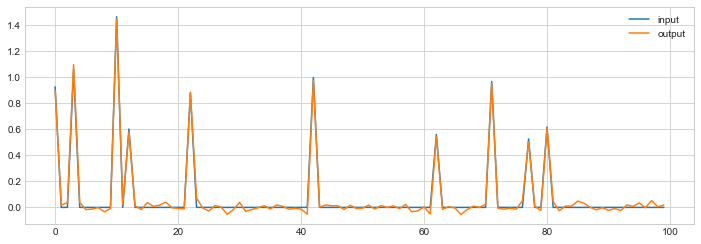

In [4]:
A, x_true, y = make_data(sigma=0.01)
x_out = simple_least_squares(A, y)

plt.figure(figsize=(12, 4))
plt.plot(x_true, label='input')
plt.plot(x_out, label='output')
plt.legend();

Problem Status: optimal


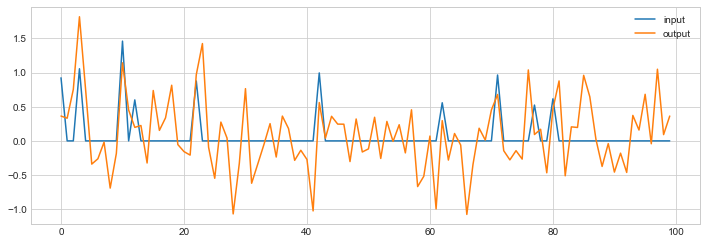

In [5]:
A, x_true, y = make_data(sigma=0.2)
x_out = simple_least_squares(A, y)

plt.figure(figsize=(12, 4))
plt.plot(x_true, label='input')
plt.plot(x_out, label='output')
plt.legend();

This is a clear sign of an ill-posed problem.

## Least Squares with L1 Regularization

In [6]:
def L1_least_squares(A, y, gamma):
    # Construct the problem.
    x = cvx.Variable(A.shape[1])
    error = cvx.sum_squares(A*x - y)
    gamma = cvx.Parameter(value=gamma, sign="positive")
    objective = cvx.Minimize(error + gamma*cvx.norm(x, 1))
    prob = cvx.Problem(objective)

    prob.solve()
    print("Problem Status: {0}".format(prob.status))
    
    return np.asarray(x.value).ravel()

Problem Status: optimal


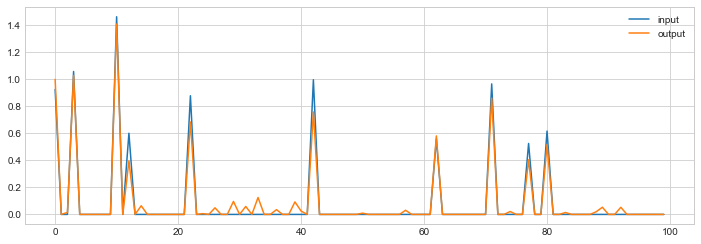

In [7]:
A, x_true, y = make_data(N=100, M=100, K=10, sigma=0.2)
x_out = L1_least_squares(A, y, gamma=10.0)

plt.figure(figsize=(12, 4))
plt.plot(x_true, label='input')
plt.plot(x_out, label='output')
plt.legend();

## Complex Least Squares with L1 regularization

Here we follow Section VI(D) of [An Interior-Point Method for Large-Scale L1-Regularized Least Squares](http://web.stanford.edu/~boyd/papers/pdf/l1_ls.pdf)

We regularize on a latent parameter *u* which gives an upper-limit on the magnitude of x.

In [8]:
def L1_least_squares_complex(A, y, gamma):
    N, M = A.shape

    # objective is ||Ax - y||^2 + gamma |u|_1
    #  with constraint abs(x_i) < u_i
    # for complex A, x, y and real u

    # Split into real and imaginary parts
    Ar, Ai = A.real, A.imag
    yr, yi = y.real, y.imag

    xr = cvx.Variable(M)
    xi = cvx.Variable(M)
    u = cvx.Variable(M)
    gamma = cvx.Parameter(value=gamma, sign="positive")

    error = cvx.sum_squares(Ar*xr - Ai*xi - yr) + cvx.sum_squares(Ai*xr + Ar*xi - yi)
    objective = cvx.Minimize(error + gamma*cvx.norm(u, 1))
    constraints = [cvx.norm(cvx.hstack(xr, xi), 2, axis=1) <= u]

    prob = cvx.Problem(objective, constraints)
    prob.solve()
    print("Problem Status: {0}".format(prob.status))

    return np.array(xr.value).ravel() + 1j * np.array(xi.value).ravel()

def L1_least_squares_complex(A, y, gamma):
    N, M = A.shape

    # objective is ||Ax - y||^2 + gamma |x|_1
    # for complex A, x, y

    # Split into real and imaginary parts
    Ar, Ai = A.real, A.imag
    yr, yi = y.real, y.imag

    xr = cvx.Variable(M)
    xi = cvx.Variable(M)
    gamma = cvx.Parameter(value=gamma, sign="positive")

    error = cvx.sum_squares(Ar*xr - Ai*xi - yr) + cvx.sum_squares(Ai*xr + Ar*xi - yi)
    u = cvx.norm(cvx.hstack(xr, xi), 2, axis=1)
    objective = cvx.Minimize(error + gamma*cvx.norm(u, 1))
    
    prob = cvx.Problem(objective)
    prob.solve()
    print("Problem Status: {0}".format(prob.status))

    return np.array(xr.value).ravel() + 1j * np.array(xi.value).ravel()

Problem Status: optimal


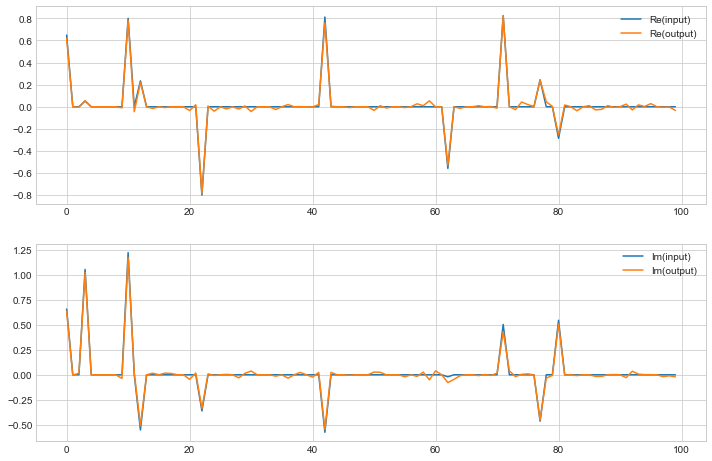

In [9]:
# Create complex data
A, x_true, y = make_data(N=100, M=100, K=10, sigma=0.2, cplx=True)
x_out = L1_least_squares_complex(A, y, gamma=1.0)

fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(x_true.real, label='Re(input)')
ax[0].plot(x_out.real, label='Re(output)')
ax[0].legend()
ax[1].plot(x_true.imag, label='Im(input)')
ax[1].plot(x_out.imag, label='Im(output)')
ax[1].legend()

plt.legend();